## The Matched Lattice
Knowing the RF cavities required to get to the necessary energies, and knowing the absorber lengths at each stage, the matched solenoids for each cells can be made, iterated via G4BL.

Step 1) Simulate a beam through one absorber, 40 T fields

Step 2) Acquire the momentum loss from the 1 sigma particles

Step 3) Generate matched solenoids from 4 T to 40 T to 4 T, considering the momentum loss from the absorber

Step 4) Simulate in G4BL the result from the matched solenoids

Step 5) Match solenoids between the RF cavities

Step 6) Simulate in G4BL the result from the matched cavities

Step 7) Correct the solenoids from the momentum increase in G4Beamline 

Step 8) Match the output with a field flip for the next cell

Repeat 10x

#### Preamble

In [1]:
# Packages
import numpy as np
import pandas as pd
import coolpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
from py2g4bl_match_helpers import P, CellBeamGen, compute_emit_from_phasespace, readfile, E_to_dpp_to_dE, plot_solenoid

from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ff3645","#bf3a68","#803e8b", "#4042ad","#0046d0"])
cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0046d0","#4042ad", "#803e8b","#bf3a68","#ff3645"])

from copy import deepcopy

In [3]:
# Global Parameters as defined by the genetic algorithm
Energies = [123.4874061 , 123.34209297, 100.41454084,  85.48562669,  74.47974494,  51.82242803,  32.01412767,  18.28142271, 17.9391355 ,  14.70422686]
AbsorberLengths = np.array([1.27736269, 1.32518469, 1.10521782, 1.13798138, 0.81575282, 0.43656683, 0.30241914, 0.10448507, 0.11920284, 0.09100977])
EnergySpreads = [5.41686927, 5.81701861, 5.25003438, 5.06819512, 5.65785391, 4.36047814, 2.39677483, 1.29680007, 1.25195259, 1.20749703]

Length_max = np.sum(AbsorberLengths)

In [4]:
# Target emittances as achieved by the simple G4BL setup
EmitT_Target = np.array([0.0002466918788431969,  0.0002026040562576625,  0.00016493170280864206,  0.00012640334072074876,  0.00010316360751668846,  8.722476322836085e-05,  6.031231528154821e-05,  4.5028352240203934e-05,  3.15684664407679e-05,  2.221710939561845e-05])
EmitL_Target = np.array([0.0018836404178010724,  0.0022763763903832462,  0.0028338086313568615,  0.003975051209763533,  0.005130191267191367,  0.006728425742772072,  0.011819326472499425,  0.020757848567312387,  0.03924855255649506,  0.07171590993046725])

In [5]:
EmitL_Target*1E3

array([ 1.88364042,  2.27637639,  2.83380863,  3.97505121,  5.13019127,
        6.72842574, 11.81932647, 20.75784857, 39.24855256, 71.71590993])

##### Define solenoid geometries

In [6]:
# Solenoid parameters
nSheet = 5
offset = 0.0

### Radius
L_radius_in  = 0.1 #[m] Low Field
L_radius_out = 0.3 #[m]
M_radius_in  = 0.1 # Matching field
M_radius_out = 0.3
H_radius_in  = 0.03 # High Field
H_radius_out = 0.09

Hcorr1_radius_out = 0.135 #outer most down and up stream correctors
Hcorr2_radius_out = 0.125 #middle  down and up stream correctors
Hcorr3_radius_out = 0.115 #inner most down and up stream correctors

### Length
L_Lsol = 1 #[m]
L_Lsol_short = 0.5 # 0.5
M_Lsol = 0.2
H_Lsol_list = [abslen + 2*0.12 for abslen in AbsorberLengths]
Hcorr_Lsol = 0.012

#### Current density ####
L_current_density = 17.  #[A/mm^2]
H_current_density = 535.3 #A mm^-2
H2_current_density = -17 #A mm^-2
M_current_density = 50 #A mm^-2

NU_matchers = 4
ND_matchers = 10

L_Lgap = 0.4
L_Hgap = 0.1
L_MUgap = 0.1
L_MDgap = 0.25+0.1
L1_pos = 0 #[m]

Define solenoid positions

In [7]:
# Setting up first cell (unique)
MU_pos_arr = [(L_Lsol/2 + L_Lgap + L_MUgap*i + M_Lsol*i + M_Lsol/2) for i in range(NU_matchers)]
H1_pos = MU_pos_arr[-1] + M_Lsol/2 + L_Hgap + H_Lsol_list[0]/2 + Hcorr_Lsol*3

H_pos_arr = np.zeros(10)
H_pos_arr[0] = H1_pos

# Finds the high field solenoid and downstream matcher positions iteratively
MD_pos_arr_all = []
for ncell in range(1, 10):
    H_pos = H_pos_arr[ncell-1]
    if H_pos != 0:
        MD_pos_arr = [(H_pos + Hcorr_Lsol*3 + H_Lsol_list[ncell-1]/2 + L_Hgap + L_MDgap*i + M_Lsol*i + M_Lsol/2) for i in range(ND_matchers)]
    H_pos_new = MD_pos_arr[-1] + M_Lsol/2 + L_Hgap + H_Lsol_list[ncell]/2 + Hcorr_Lsol*3
    MD_pos_arr_all.append(np.array(MD_pos_arr))
    H_pos_arr[ncell] = H_pos_new
MD_pos_arr_all = np.array(MD_pos_arr_all)


In [8]:
# Same but for the high-field correctors
Hcorr_rad_arr = [Hcorr1_radius_out, Hcorr2_radius_out, Hcorr3_radius_out]

HcorrU_pos_arr_all = []
HcorrD_pos_arr_all = []

for ncell in range(10):
    HcorrU_arr = [(H_pos_arr[ncell] - (H_Lsol_list[ncell]*0.5 + Hcorr_Lsol*(3-i)) + Hcorr_Lsol*0.5) for i in range(3)]
    HcorrD_arr = [(H_pos_arr[ncell] + (H_Lsol_list[ncell]*0.5 + Hcorr_Lsol*(3-i)) - Hcorr_Lsol*0.5) for i in range(3)]
    HcorrU_pos_arr_all.append(np.array(HcorrU_arr))
    HcorrD_pos_arr_all.append(np.array(HcorrD_arr))

Generate solenoid models with coolpy

In [9]:
fieldflip = np.tile([1, -1], 5)

In [10]:
# First Cell
L1 = cp.SolenoidSheet(current_density=L_current_density, radius_inner=L_radius_in, radius_outer=L_radius_out, rho=offset, L_sol=L_Lsol, nSheet=nSheet, position=L1_pos)
MU1_list = [cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MU_pos_arr[m]) for m in [0, 2, 3]]

# Matching solenoids
MD_solenoid_list = []
for ncell in range(9):
    for m in range(ND_matchers):
        MD_list = cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MD_pos_arr_all[ncell][m])
        MD_solenoid_list.append(MD_list)


In [11]:
# High field solenoids and correctors
H_solenoid_list = [cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=H_radius_out, rho=offset, L_sol=H_Lsol_list[ncell], nSheet=nSheet, position=H_pos_arr[ncell]) for ncell in range(10)]

HcorrU_solenoid_list = []
HcorrD_solenoid_list = []
for ncell in range(10):
    for corr in range(3):
        HcorrU = cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrU_pos_arr_all[ncell][corr])
        HcorrD = cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrD_pos_arr_all[ncell][corr])
        HcorrU_solenoid_list.append(HcorrU)
        HcorrD_solenoid_list.append(HcorrD)

Combine solenoid models to get analytical fields

In [12]:
def get_matching_solenoid_index(cell: int, offset: int) -> range:
    return range(10 * (cell - 1) + offset, 10 * cell + offset)

In [16]:
MU_optimized_params = [34.07907333777548, 3.3219755405093148, 51.652979865357764]

for m, matcher in enumerate(MU1_list):
    matcher.current_density = MU_optimized_params[m]

#MD1_optimized_params = np.array([35.508740647947036, -7.775637580448505, -12.148933874280392, 1.1659173138855703, -14.173355652807334, 3.1998081438712456, 2.3815554497724882, -9.459754369901425, 24.349408687342134, -45.67855729411018])
#MD2_optimized_params = np.array([-28.31789277065613, -18.501887818005812, -1.8784318575656016, -0.7270962827746912, -18.06964647404582, -8.53553912519761, 0.0009505872611441622, 9.413088307598954, 20.368889231178734, 29.575276718397387])
#MD3_optimized_params = np.array([20.850624369473344, 12.413159406555176, -11.020477105084112, -4.4959745919857355, -1.2261645525741547, -7.944903700775784, -0.02232899339689541, 11.214227282445574, -15.610248028781658, -24.94776206574598])
#MD4_optimized_params = np.array([-30.10777573536053, 16.754070695307373, -11.847294928772918, 9.937535310012745, -7.382114373194557, 8.695539334740689, 13.679726322160738, 17.198860048441876, 18.27987415942097, 32.30642320204957])
#MD5_optimized_params = np.array([11.343974014339874, 12.336638733666955, -7.14255313126038, 0.765784357408995, -1.312317853070624, 7.019639246966744, 1.127414852195843, 11.369090082700511, -8.053117866227542, -21.067312426060433] )
#MD6_optimized_params = np.array([-21.49148506645938, -15.017781723049705, 14.406865606476686, 18.694530436181793, -16.102623903649572, -7.952328947438012, 12.561827306816, -8.000509582115589, 17.426440855050668, 27.430956877734616])
#MD7_optimized_params = np.array([29.792987462002387, -12.763595718600296, -28.990955354902574, 10.769888120436011, -6.448759848624242, -5.185552678204381, -14.743813821719531, 11.217477407701237, -9.595475068755617, -30.409549227155907])
#MD8_optimized_params = np.array([-22.053040769011826, -15.389054394144107, 13.418263668885078, 19.058865525103563, -14.513990372251277, -8.22610135643363, 11.561728700959243, -8.41556114530449, 18.02540058315934, 28.403136256583092])
#MD9_optimized_params = np.array([24.90996132453933, -10.12802897056051, -30.352135584470346, 8.86821549314558, -8.077319330293964, -6.019592753431176, -13.850729144435995, 15.243303750935036, -4.801301343959765, -31.23911694442866])

MD1_optimized_params = [35.508740647947036, -7.775637580448505, -12.148933874280392, 1.1659173138855703, -14.173355652807334, 3.1998081438712456, 2.3815554497724882, -9.459754369901425, 24.349408687342134, -45.67855729411018]
MD2_optimized_params = [-28.334138602427913, -18.431715440219733, -1.8529310774283174, -0.7396277735737722, -18.08609030347646, -8.54763195601096, 0.0009673962361045998, 9.52430341142502, 20.397960787679445, 29.556592977301975]
MD3_optimized_params = [21.012621654497096, 12.244461370921899, -11.097449571960091, -4.5045177322268195, -1.2384944237811228, -8.106579877886627, -0.022295960992406223, 11.267593100105538, -15.663338462735148, -24.942415716187753]
MD4_optimized_params = [-29.881346668714592, 16.744336886371848, -11.819662580805698, 9.950325737531157, -7.483195432733175, 8.724360618218066, 13.792092053439175, 17.363911559598638, 18.412403662763268, 32.41448982831251]
MD5_optimized_params = [11.369558929743466, 12.310983999339264, -7.198581912134298, 0.7722998442491082, -1.3293470467535062, 7.025454878824878, 1.1407216424801891, 11.469503794614873, -7.918146505524364, -21.16029651285568]
MD6_optimized_params = [-9.351199516185929, -8.265483470824226, -5.642855921818294, -1.6810582839808403, -0.10171718576806638, -0.7056563222222092, -3.4193851559764092, 6.131475790137806, 8.008457203287477, 9.299822544002978]
MD7_optimized_params = [7.647602416613121, 4.3973410507563, -3.47664895621583, -3.23381354548873, 0.36024739488718593, 1.8285887361704665, 3.1151628772141673, 4.260515394876277, -5.064935915662694, -7.099356339291422]
MD8_optimized_params = [-3.0, -3.0, -2.9097644512676304, -1.7544701789369905, -0.9130424166269479, 1.1217040669560694, 2.9999990742060376, 3.0, 3.0, 2.970215956564008]
MD9_optimized_params = [1.0583103982607092, 1.0500455941704727, 1.9252227367437993, 1.4278263534742615, 1.945881674263419, 1.8739729691909845, 1.9480803385146983, -1.85545832857671, -1.6358049231199687, -1.318972828853515]

MD_current_densities = [MD1_optimized_params, MD2_optimized_params, MD3_optimized_params, MD4_optimized_params, MD5_optimized_params, MD6_optimized_params, MD7_optimized_params, MD8_optimized_params, MD9_optimized_params]

NCELL_RANGE = range(1,10)
for ncell in NCELL_RANGE:
    for m, matcher in enumerate(np.array(MD_solenoid_list)[get_matching_solenoid_index(ncell, 0)]):
        matcher.current_density = MD_current_densities[ncell-1][m]
        #matcher.current_density = (optimisation_map[ncell-1]['params'])[m]

In [17]:
import matplotlib.patches as patches

[(0.0, 60.28217328000004), (-0.5, 0.5)]

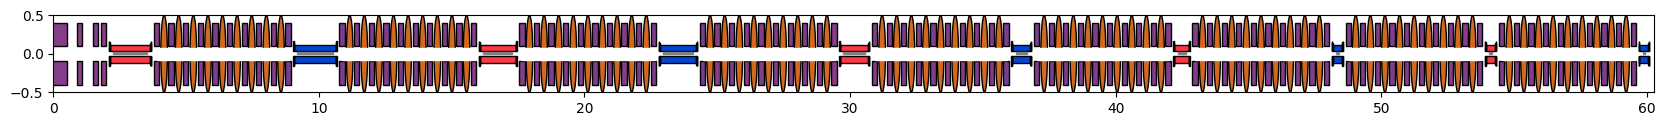

In [19]:
#Construct beamline
sol_list = [L1] + MU1_list + MD_solenoid_list + H_solenoid_list + HcorrU_solenoid_list + HcorrD_solenoid_list

mag_field = cp.MagneticField()
[mag_field.add_solenoid(solenoid) for solenoid in sol_list];

fig = plt.figure(figsize=(25,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
plt.subplots_adjust(hspace=0)

I_max = H_current_density

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)
for s, solenoid in enumerate(MD_solenoid_list):
    if s%10 < 9:
        RF_cavity = patches.Ellipse((solenoid.position + 0.285,0), 0.25, 1, linewidth=1, edgecolor='k',facecolor='chocolate')
        ax1.add_patch(RF_cavity)
for i in range(0,10):
    absorber = patches.Rectangle((H_solenoid_list[i].position-AbsorberLengths[i]/2, 0), AbsorberLengths[i], 0.025, color='grey')
    ax1.add_patch(absorber)

for i in range(0,9):
    start_pos = MD_solenoid_list[i*10].position
    gap_length = 0.25*20
    gap_width = 0.15
    RF_gap = patches.Rectangle((start_pos, -gap_width/2), gap_length, gap_width, color='white')
    ax1.add_patch(RF_gap)

ax1.set(xlim=(0, solenoid.position+solenoid.L_sol*4), ylim=(-0.5, 0.5))

In [20]:
matplotlib.rcParams.update({'font.size': 18})

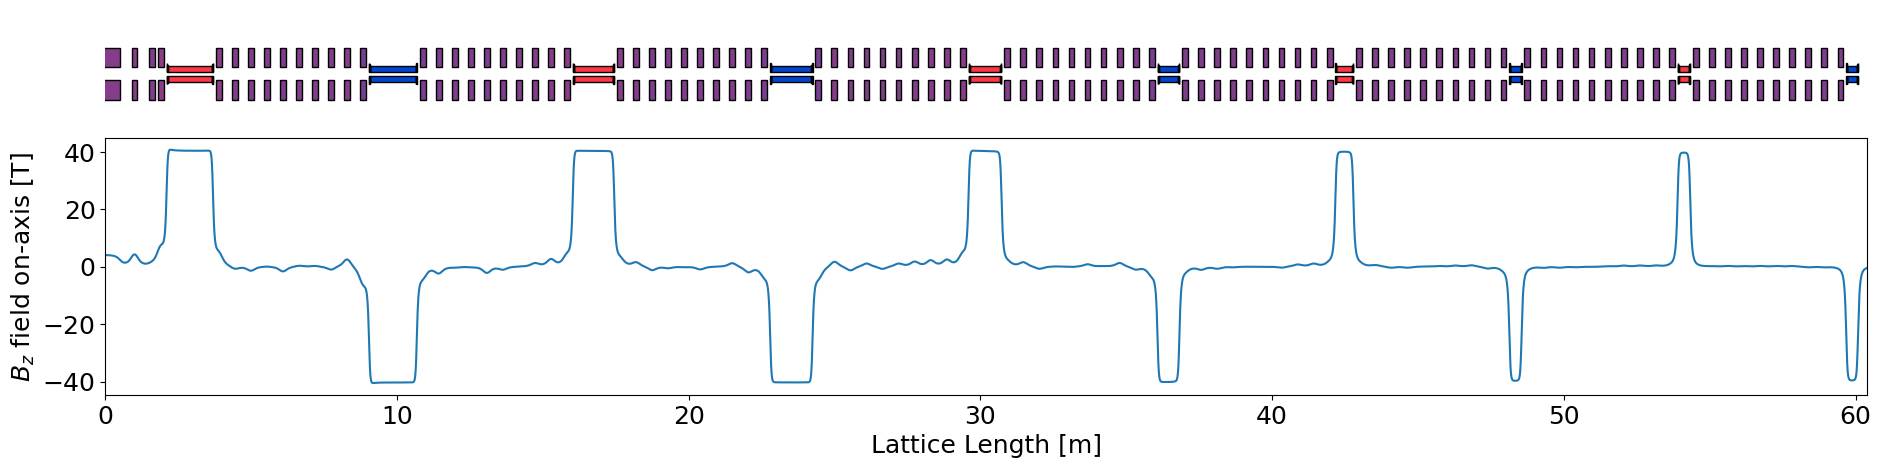

In [21]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(25,5))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[0.5, 1], width_ratios=[1, 0.0])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
plt.subplots_adjust(hspace=0)

s = np.arange(0., H_pos_arr[-1] + 0.5, 0.001)
B_superposed = mag_field.superposed_field_z(s)

I_max = H_current_density
max_S = H_pos_arr[-1]+ 0.5 # max(s)
max_r = 1

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s, B_superposed)
ax2.set(ylabel=(r'$B_z$ field on-axis [T]'), xlabel="Lattice Length [m]", xlim=(0, max_S))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()

#ax1.set_title('10 Cells: Solenoid Spacing & B-Fields')
plt.show()

In [22]:
EmitT_Target = np.array([0.0003, 0.0002466918788431969,  0.0002026040562576625,  0.00016493170280864206,  0.00012640334072074876,  0.00010316360751668846,  8.722476322836085e-05,  6.031231528154821e-05,  4.5028352240203934e-05,  3.15684664407679e-05,  2.221710939561845e-05])

#### Functions for calculating beta and for optimisations

In [23]:
def beta_system(s_, b, kappa_interp, L):
    b1, b2 = b
    db1ds = b2
    k_s = kappa_interp(s_)
    db2ds = (b2**2 + 4*(1 + L**2) - 4*b1**2 * k_s**2) / (2 * b1)
    return [db1ds, db2ds]

In [24]:
def interp_beta(s_, B_superposed, momentum):
    kappa = abs(cp.Gc_2 * B_superposed / momentum)
    kappa_interp = interp1d(s_, kappa, kind='linear', fill_value="extrapolate")
    b0 = [1/kappa_interp(0), 0.]
    L=0
    solution = solve_ivp(fun=beta_system, t_span=[s_[0], s_[-1]], t_eval=s_, y0=b0, args=(kappa_interp, L))
    #beta_interp = interp1d(s,  solution[:,0], kind='linear', fill_value="extrapolate")
    #betaP_interp = interp1d(s, solution[:,1], kind='linear', fill_value="extrapolate")
    return(solution.y[0],  solution.y[1])

In [25]:
def calc_beta_betap(mag_field_, s_, p1, p2, p3):
    #L = 0.
    B_superposed_ = mag_field_.superposed_field_z(s_)
    beta_interp1, betaP_interp1 = interp_beta(s_, B_superposed_, p1)
    beta_interp2, betaP_interp2 = interp_beta(s_, B_superposed_, p2)
    beta_interp3, betaP_interp3 = interp_beta(s_, B_superposed_, p3)
    return([beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed_)

In [49]:
def objective(params, matching_index, MD_matchers_, s_, all_solenoids, p1_interp, p2_interp, p3_interp, points, weights=[1,0,1,100], extra_condition='None'):
    p1 = p1_interp(s_)
    p2 = p2_interp(s_)
    p3 = p3_interp(s_)

    w1, w2, w3, wp = weights

    npoints = len(points)

    magfields, b1, b1p, b2, b2p, b3, b3p = solve_ode(matching_index, MD_matchers_, params, [p1, p2, p3], s_, all_solenoids) #Calculates the beta and beta' for one momenta set 

    B_superposed = magfields.superposed_field_z(s_) # Gets the mag_field layout which has been updated from solve_ode
    B_interpol = cp.B_field_interpol(s_, B_superposed) # Gets the field just at s-points 

    beta0_idal_1 = abs(p1_interp(points) / cp.Gc_2 / B_interpol(points)) # Calculates what the beta should be, considering the momentum and field
    b1_points = np.interp(points, s_, b1)
    err_b_1 = np.sum(abs(beta0_idal_1 - b1_points))/npoints # Error between what the beta should be, and what the magfield gives
    b1p_points = np.interp(points, s_, b1p)
    err_b_prime_1 = np.sum((abs(b1p_points) )**2)/npoints # There is no ideal beta_prime, so instead we consider difference from zero
    err1 = err_b_1 + wp*err_b_prime_1

    beta0_idal_2 = abs(p2_interp(points) / cp.Gc_2 / B_interpol(points)) # Calculates what the beta should be, considering the momentum and field
    b2_points = np.interp(points, s_, b2)
    err_b_2 = np.sum(abs(beta0_idal_2 - b2_points))/npoints # Error between what the beta should be, and what the magfield gives
    b2p_points = np.interp(points, s_, b2p)
    err_b_prime_2 = np.sum((abs(b2p_points) )**2)/npoints # There is no ideal beta_prime, so instead we consider difference from zero
    err2 = err_b_2 + wp*err_b_prime_2

    beta0_idal_3 = abs(p3_interp(points) / cp.Gc_2 / B_interpol(points))# Calculates what the beta should be, considering the momentum and field
    b3_points = np.interp(points, s_, b3)
    err_b_3 = np.sum(abs(beta0_idal_3 - b3_points))/npoints # Error between what the beta should be, and what the magfield gives
    b3p_points = np.interp(points, s_, b3p)
    err_b_prime_3 = np.sum((abs(b3p_points) )**2)/npoints # There is no ideal beta_prime, so instead we consider difference from zero
    err3 = err_b_3 + wp*err_b_prime_3

    err = w1*err1 + w2*err2 + w3*err3

    if extra_condition != 'None':
        MD_points = [matcher.position for matcher in np.array(MD_solenoid_list)[get_matching_solenoid_index(NCELL_MATCH,0)]]
        npoints_MD = len(MD_points)
        b1_extra_points = np.interp(MD_points, s_array, b1)
        b1_result = np.where(b1_extra_points < extra_condition, 0, b1_extra_points - extra_condition) #Adds an error if beta is greater than 2

        bp1_extra_points = np.interp(MD_points, s_array, b1p)
        bp1_result = abs(np.where(abs(bp1_extra_points) < extra_condition, 0, abs(b1_extra_points) - extra_condition)) #Adds an error if beta is greater than 2

        err_b1_extra = np.sum(b1_result) + np.sum(bp1_result) # Sum and divide

        b3_extra_points = np.interp(MD_points, s_array, b3)
        b3_result = np.where(b3_extra_points < extra_condition, 0, b3_extra_points - extra_condition) # Adds an error if beta is greater than 2

        bp3_extra_points = np.interp(MD_points, s_array, np.abs(b3p))
        bp3_result = abs(np.where(abs(bp3_extra_points) < extra_condition, 0, abs(b3_extra_points) - extra_condition)) #Adds an error if beta is greater than 2

        err_b3_extra = np.sum(b3_result) + np.sum(bp3_result) # Sum and divide
        
        err += err_b1_extra + err_b3_extra
    print(params.tolist(), err)

    return err

In [50]:
def solve_ode(matching_index, MD_matchers_, params, Momentum, s_, all_solenoids):
    #L = 0
    
    for m, M in enumerate(matching_index):
        MD_matchers_[M].current_density = params[m]

    #Construct beamline
    sol_list_ = all_solenoids + MD_matchers_
    mag_field_ = cp.MagneticField()
    [mag_field_.add_solenoid(solenoid) for solenoid in sol_list_]

    B_superposed = mag_field_.superposed_field_z(s_)
    b1, b1_p = interp_beta(s_, B_superposed, Momentum[0])
    b2, b2_p = interp_beta(s_, B_superposed, Momentum[1])
    b3, b3_p = interp_beta(s_, B_superposed, Momentum[2])

    return mag_field_, b1, b1_p, b2, b2_p, b3, b3_p

In [51]:
def compute_emit_from_phasespace(beam):
    m_mu = 0.105658375
    c= cp.c
    ref_charge = 0.299792458
    X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
    BZ = beam['Bz']
    E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5

    filt = True

    if filt:
        # Stack the variables for easier filtering
        data = np.stack([X, PX, Y, PY, T, E])
        # Calculate the mean and standard deviation of each variable
        means = np.mean(data, axis=1)
        stds = np.std(data, axis=1)
        # Identify high amplitude particles (above 5 sigma)
        sigma = 5
        filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
        # Filter the data
        filtered_data = data[:, filtered_indices]
        
        # Compute the covariance matrix of the filtered data
        Cov = np.cov(filtered_data)
    else:
        Cov = np.cov([X,PX,Y,PY,T,E])

    Cov4D = Cov[0:4, 0:4]
    Covz = Cov[4:6, 4:6]
    
    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 
    emitZ = (np.linalg.det(Covz) )**(0.5) * c / cp.m_mu
    
    Pzaverage = np.mean(PZ)
    Bzaverage = np.mean(BZ)
    emi4D_geo = emi4D_ * m_mu / Pzaverage
    
    xpy = Cov[0][3]
    ypx = Cov[1][2]
    xx = Cov[0][0]
    yy = Cov[2][2]
    
    L_ = (Bzaverage*ref_charge*0.5*(xx + yy) - (ypx - xpy )) * 0.5 / m_mu / emi4D_
    
    try:
        Cov4D_inv = np.linalg.inv(Cov4D)
    except np.linalg.LinAlgError:
        print(filtered_data)
        return np.nan, np.nan, np.nan
    U = np.stack(filtered_data[:4], axis=1)
    A = np.einsum('ij,jk,ik->i', U , Cov4D_inv, U ) * emi4D_geo

    ampsq_sp = A
    #ampsq_sp = (term1 + term2 + term3 +term4)/m_mu

    CovL = np.cov([np.array(filtered_data[4]), np.array(filtered_data[5]), ampsq_sp])
    AAT = CovL[2,2]
    emiL_ = (np.linalg.det(CovL) )**(0.5) / m_mu * ref_charge / (AAT**0.5)
    return emi4D_, emiL_, emitZ, L_


In [29]:
def compute_optics_from_phasespace(beam):
    m_mu = 0.105658375
    X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
    E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5

    filt = True

    if filt:
        # Stack the variables for easier filtering
        data = np.stack([X, PX, Y, PY, T, E])
        # Calculate the mean and standard deviation of each variable
        means = np.mean(data, axis=1)
        stds = np.std(data, axis=1)
        # Identify high amplitude particles (above 5 sigma)
        sigma = 5
        filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
        # Filter the data
        filtered_data = data[:, filtered_indices]
        
        # Compute the covariance matrix of the filtered data
        Cov = np.cov(filtered_data)
    else:
        Cov = np.cov([X,PX,Y,PY,T,E])

    Cov4D = Cov[0:4, 0:4]
    Covx = Cov[0:2, 0:2]
    Covy = Cov[2:4, 2:4]

    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 

    Pzaverage = np.mean(PZ)
    emi4D_geo = emi4D_ * m_mu / Pzaverage

        #normalized emittances
    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 

    #geometrical emittances 
    emi4D_geo = emi4D_ * m_mu / Pzaverage

    beta_perp_ = (Covx[0][0] + Covy[0][0])*0.5/emi4D_geo
    alpha_perp_ = -(Covy[0][1]+Covx[0][1]) *0.5 / emi4D_geo

    return(beta_perp_, alpha_perp_)

#### G4Beamline setup

Definitions, absorbers and coils

In [396]:
setup = f'''
g4ui when=4 "/vis/viewer/set/background 1 1 1"
param disable=Decay   #Whether muons decay
param stochastics=1
physics QGSP_BIC disable=$disable
param cell_end={(H_pos_arr[-1]+H_Lsol_list[-1]/2)*1E3}
param zstep=50
'''

absorber_list = []
highcoil_list = []
for cellno in [0,1,2,3,4,5,6,7,8,9]:
    absorbers = f'''
tube abs{cellno} length={AbsorberLengths[cellno]*1E3} material=LH2 innerRadius=0 outerRadius=25 color=1,1,1,1
place abs{cellno} z={H_pos_arr[cellno]*1E3:.2f}'''
    absorber_list.append(absorbers)

for cellno in range(10):
    highcoils = f'''
coil H{cellno+1}_C innerRadius=30 outerRadius=90 length={H_solenoid_list[cellno].L_sol*1E3} nSheets=3 tolerance=1 maxZ=7000'''
    highcoil_list.append(highcoils)

coils = f'''
### Low Field
coil L1_C innerRadius=100 outerRadius=300 length={L1.L_sol*1E3} nSheets=3 tolerance=1 maxZ=7000

### High Field
coil Hcorr1_C innerRadius=30 outerRadius=135 length=12 nSheets=3 tolerance=1 maxZ=7000
coil Hcorr2_C innerRadius=30 outerRadius=125 length=12 nSheets=3 tolerance=1 maxZ=7000
coil Hcorr3_C innerRadius=30 outerRadius=115 length=12 nSheets=3 tolerance=1 maxZ=7000

# Matchers
coil M_C innerRadius=100 outerRadius={M_radius_out*1E3} length={M_Lsol*1E3} nSheets=10 tolerance=1 maxZ=7000
'''

low_solenoid = f'''
solenoid L1 coil=L1_C current=17.0 color=0.929,0.616,0.035,1
place L1 z=0'''


High field solenoids and high field corrections

In [397]:
high_solenoids = []
for cellno, Hsol in enumerate(H_solenoid_list):
    if Hsol.current_density > 0:
           color='1,0,0,0.5'
    else:
           color='0,0,1,0.5'
    highsolenoid = f'''
solenoid H{cellno+1} coil=H{cellno+1}_C current={Hsol.current_density} color={color}
place H{cellno+1} z={Hsol.position*1E3}'''
    high_solenoids.append(highsolenoid)
    
HCorrU_solenoids = []
for u, hcorr in enumerate(HcorrU_solenoid_list):
        if hcorr.current_density > 0:
                color='1,0,0,0.5'
        else:
                color='0,0,1,0.5'
        HCU = f'''
solenoid H{u//3+1}corr{u%3+1}_U coil=Hcorr{u%3+1}_C current={hcorr.current_density} color={color}
place H{u//3+1}corr{u%3+1}_U z={hcorr.position*1E3}'''
        HCorrU_solenoids.append(HCU)
        
HCorrD_solenoids = []
for d, hcorr in enumerate(HcorrD_solenoid_list):
        if hcorr.current_density > 0:
                color='1,0,0,0.5'
        else:
                color='0,0,1,0.5'
        HCD = f'''
solenoid H{d//3+1}corr{d%3+1}_U coil=Hcorr{d%3+1}_C current={hcorr.current_density} color={color}
place H{d//3+1}corr{d%3+1}_U z={hcorr.position*1E3}'''
        HCorrD_solenoids.append(HCD)

Matching solenoids upstream and downstream/rf

In [398]:
MU_pos_arr = [1.0, 1.6, 1.9000000000000004]
MU_solenoids = []
for i in range(3):
    MU = f'''
solenoid MU{i+1} coil=M_C current={MU1_list[i].current_density} color=1,0,1,1
place MU{i+1} z={MU_pos_arr[i]*1E3}'''
    MU_solenoids.append(MU)

MD_solenoids = []
for md, Matcher in enumerate(MD_solenoid_list):
    MD = f'''
solenoid MD{md//10+1}_{md%10+1} coil=M_C current={Matcher.current_density} color=1,0,1,1
place MD{md//10+1}_{md%10+1} z={Matcher.position*1E3}'''
    MD_solenoids.append(MD)


RF definitions

Single reference particle tracking

In [416]:
N = 10000

In [417]:
track_p0 = f'''
param ref_p={P((Energies[0])*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p0.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_Reference.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={3} # user provided file with particle data
trackcuts keep=mu+
'''

track_p1 = f'''
param ref_p={P((Energies[0]-EnergySpreads[0]/2)*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p1.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={1} # user provided file with particle data
trackcuts keep=mu+
'''

track_p2 = f'''
param ref_p={P((Energies[0]+EnergySpreads[0]/2)*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p2.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={1} # user provided file with particle data
trackcuts keep=mu+
'''

track_all = f'''
param kinetic_energy={Energies[0]}
param ref_p={P(Energies[0]*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_{N}.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={N} # user provided file with particle data
trackcuts keep=mu+

'''

In [418]:
# Without timeOffset=0
rf_rot_grad_arr = [2*32, 2*32, 2*15,  60,  150, 30, 30, 30, 30]
rf_grad_arr     = [32,     17,   18,  25,   10, 20, 15, 15, 15]
acc_freq_arr    = [50,       0,    0,  0,     0, 0, 0, 0, 0]
rot_freq_arr    = [50,     50,   50,  50,   50, 50, 50, 50, 50]
acc_phase_arr   = [50,     50,   50,  10,   10, 50, 50, 50, 50]

# With timeOffset=0
                   #1   2      3    4     5    6   7    8   9
rf_rot_grad_arr = [19,  19,    19,  6,   20,  20, 20,  10, 6]
rf_grad_arr     = [33,  16,    18,  25,   8,  25, 4.5,  6, 6.5]
acc_freq_arr    = [1,    1,    1,   1,    1,  10, 1,    1,  1]
rot_freq_arr    = [50,  50,   50,  50,   20,  10, 10,  10, 5]
acc_phase_arr   = [90,  90,   90,  90,   90,  0,  90,  90, 90]
rot_phase_arr   = [0,   0,    0,    0,    0, 180, 0,    0,  0]

acc_rot_swap_cell = 5

rf_list = []
for rf, Matcher in enumerate(MD_solenoid_list):
    rf_no, cell_no = rf%10, rf//10

    if cell_no < acc_rot_swap_cell: #Rotation first, then acceleration
        if rf_no >= 9: #There is no 10th solenoid
            pass
        else:
            if timeOffsetbool == True:
                try:
                    timeOffset = timeOffset_dict[f'rf{cell_no+1}_{rf_no+1}']
                    timeOffset_str = f'timeOffset={timeOffset}'
                except:
                    timeOffset_str = ''
            elif timeOffsetbool == False:
                timeOffset_str = ''
            rf1_pos= Matcher.position+0.25+0.05/2
            if rf_no < 4: #Rotational cavities
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={rot_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            if rf_no >= 4:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)
    elif cell_no >= acc_rot_swap_cell:
        if rf_no >= 9: #There is no 10th solenoid
            pass
        else:
            if timeOffsetbool == True:
                try:
                    timeOffset = timeOffset_dict[f'rf{cell_no+1}_{rf_no+1}']
                    timeOffset_str = f'timeOffset={timeOffset}'
                except:
                    timeOffset_str = ''
            elif timeOffsetbool == False:
                timeOffset_str = ''
            rf1_pos= Matcher.position+0.25+0.05/2
            if rf_no <3: #Rotational cavities
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={rot_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            if rf_no >=3:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)

Write and run g4bl file

In [419]:
with open(f'Cell10_Ver0.00_220825.g4bl', "w") as f:
        f.write('output g4bl_log.txt')
        f.write(setup)
        f.write(coils)
        f.write(low_solenoid)
        for cellno in range(len(absorber_list)):
                f.write(absorber_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(highcoil_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(high_solenoids[cellno])
        f.write('''
                ''')
        for hcorr in HCorrU_solenoids:
                f.write(hcorr)
        for hcorr in HCorrD_solenoids:
                f.write(hcorr)
        f.write('''
                ''')
        for MU in MU_solenoids:
                f.write(MU)
        f.write('''
                ''')
        for MD in MD_solenoids:
                f.write(MD)
        f.write('''
                ''')
        for rf in rf_list:
                f.write(rf)
        f.write('''
                ''')
        f.write(track_all)
        #f.write(track_p0)
        #f.write(track_p1)
        #f.write(track_p2)

subprocess.run([r"C:\Program Files\Muons, Inc\G4beamline\bin\g4bl.exe", f"Cell10_Ver0.00_220825.g4bl"])

CompletedProcess(args=['C:\\Program Files\\Muons, Inc\\G4beamline\\bin\\g4bl.exe', 'Cell10_Ver0.00_220825.g4bl'], returncode=0)

In [284]:
def extract_time_offsets(path):
    result = {}
    with open(path, "r") as f:
        for line in f:
            if line.startswith("pillbox"):
                parts = line.split()
                # parts[1] is like "rf1_1:"
                key = parts[1].rstrip(":")
                # find "timeOffset="
                for p in parts:
                    if p.startswith("timeOffset="):
                        value = float(p.split("=")[1])
                        result[key] = value
                        break
    return result

if timeOffsetbool == False:
    timeOffset_dict = extract_time_offsets('g4bl_log.txt')
    timeOffsetbool = True

In [281]:
timeOffsetbool = False

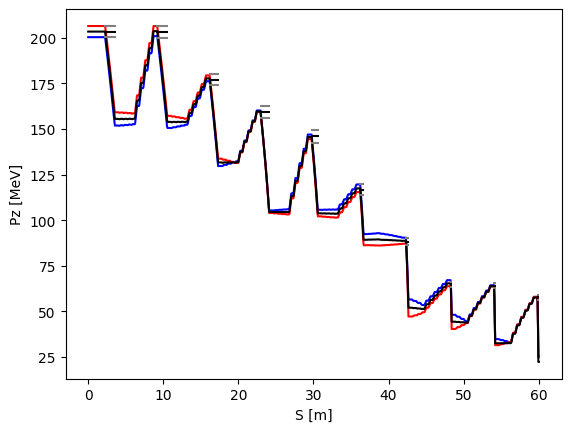

In [288]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p1.txt', 'for009')
sol_df1 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p2.txt', 'for009')
sol_df2 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p0.txt', 'for009')
sol_df0 = pd.DataFrame(track_dict)

plt.plot(sol_df1[sol_df1.IEVT==0].Z, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'sigma -ve')
plt.plot(sol_df2[sol_df2.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'r', label=f'sigma +ve')
plt.plot(sol_df0[sol_df0.IEVT==0].Z, sol_df0[sol_df0.IEVT==0].Pz*1E3, 'k', label=f'mean KE')

plt.ylabel('Pz [MeV]'), plt.xlabel('S [m]')

for i in range(10):
    plt.hlines(P((Energies[i]-EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P((Energies[i]+EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k', label='Energy Targets')
#plt.legend()


#plt.plot(sol_df1[sol_df1.IEVT==0].Z, 50 - sol_df1[sol_df1.IEVT==0].Pz*1E3 + sol_df2[sol_df2.IEVT==0].Pz*1E3, 'b', label=f'diff sigma')

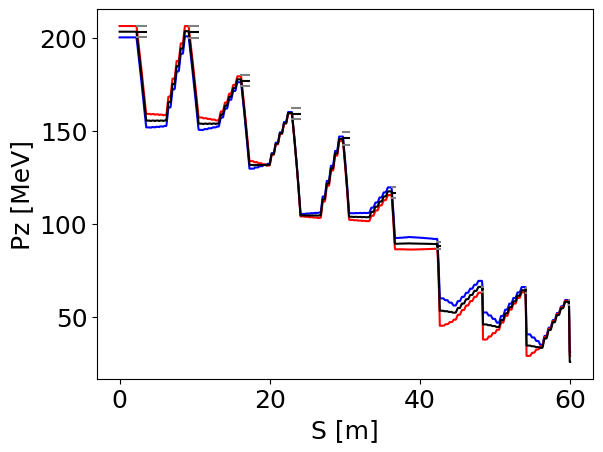

In [31]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p1.txt', 'for009')
sol_df1 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p2.txt', 'for009')
sol_df2 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p0.txt', 'for009')
sol_df0 = pd.DataFrame(track_dict)

plt.plot(sol_df1[sol_df1.IEVT==0].Z, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'sigma -ve')
plt.plot(sol_df2[sol_df2.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'r', label=f'sigma +ve')
plt.plot(sol_df0[sol_df0.IEVT==0].Z, sol_df0[sol_df0.IEVT==0].Pz*1E3, 'k', label=f'mean KE')

plt.ylabel('Pz [MeV]'), plt.xlabel('S [m]')

for i in range(10):
    plt.hlines(P((Energies[i]-EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P((Energies[i]+EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k', label='Energy Targets')
#plt.legend()


#plt.plot(sol_df1[sol_df1.IEVT==0].Z, 50 - sol_df1[sol_df1.IEVT==0].Pz*1E3 + sol_df2[sol_df2.IEVT==0].Pz*1E3, 'b', label=f'diff sigma')

In [289]:
pid1_PMev, pid2_PMev, pid3_PMev, s1_particle, s2_particle, s3_particle = sol_df1[sol_df1.IEVT==0].Pz*1E3, sol_df0[sol_df0.IEVT==0].Pz*1E3, sol_df2[sol_df2.IEVT==0].Pz*1E3, sol_df1[sol_df1.IEVT==0].Z, sol_df0[sol_df0.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Z
# With linear decrease
p1_interp = interp1d(s1_particle, 1E-3*pid1_PMev, kind='linear', fill_value="extrapolate")
p2_interp = interp1d(s2_particle, 1E-3*pid2_PMev, kind='linear', fill_value="extrapolate")
p3_interp = interp1d(s3_particle, 1E-3*pid3_PMev, kind='linear', fill_value="extrapolate")

In [420]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_{N}.txt', 'for009')
sol_df = pd.DataFrame(track_dict)

In [421]:
sol_df[sol_df.Z == sol_df.Z.max()]

,IEVT,IPNUM,IPTYP,IPFLG,JSRG,T,X,Y,Z,Px,...,By,Bz,Weight,Ex,Ey,Ez,SARC,POLx,POLy,POLz
11187525,0.0,1.0,2.0,0.0,1201.0,3.265310e-07,0.000000,0.000000,60.0,0.000000,...,0.000000,-38.8803,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11187526,2.0,0.0,2.0,0.0,1201.0,2.994710e-07,-0.000082,-0.001765,60.0,-0.005624,...,0.026468,-38.8844,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11187527,4.0,0.0,2.0,0.0,1201.0,3.068430e-07,-0.000278,-0.000758,60.0,-0.003615,...,0.011362,-38.8822,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11187528,5.0,0.0,2.0,0.0,1201.0,3.182870e-07,-0.000281,-0.001087,60.0,-0.010954,...,0.016292,-38.8829,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11187529,7.0,0.0,2.0,0.0,1201.0,3.223200e-07,-0.000240,0.000363,60.0,-0.002727,...,-0.005435,-38.8813,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11191635,9993.0,0.0,2.0,0.0,1201.0,3.084510e-07,0.000664,-0.001323,60.0,-0.002775,...,0.019828,-38.8837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11191636,9994.0,0.0,2.0,0.0,1201.0,3.170670e-07,-0.001269,0.000847,60.0,-0.006365,...,-0.012694,-38.8838,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11191637,9995.0,0.0,2.0,0.0,1201.0,3.271050e-07,0.000073,0.000261,60.0,-0.001923,...,-0.003920,-38.8809,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11191638,9996.0,0.0,2.0,0.0,1201.0,3.159000e-07,-0.000187,0.000577,60.0,-0.003667,...,-0.008657,-38.8817,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


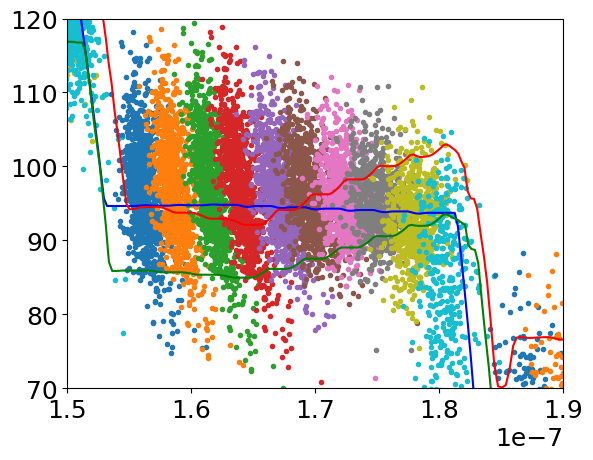

In [171]:
for md_solenoid in MD_solenoid_list:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')], 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')

plt.ylim(70, 120)
plt.xlim(15E-8, 19E-8)

plt.plot(sol_df0[sol_df0.IEVT==0]['T'], sol_df0[sol_df0.IEVT==0].Pz*1E3, 'b', label=f'Mean KE - Ref')
plt.plot(sol_df0[sol_df0.IEVT==1]['T'], sol_df0[sol_df0.IEVT==1].Pz*1E3, 'r', label=f'-Sig KE')
plt.plot(sol_df0[sol_df0.IEVT==3]['T'], sol_df0[sol_df0.IEVT==3].Pz*1E3, 'g', label=f'+Sig KE')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

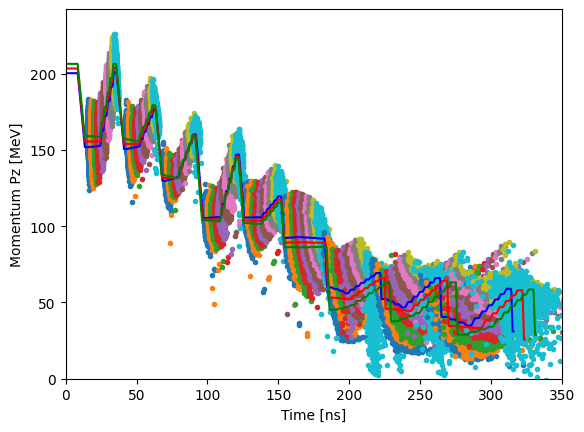

In [138]:
for md_solenoid in MD_solenoid_list:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')

plt.plot(sol_df1[sol_df1.IEVT==0]['T']*1E9, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'Mean KE - Ref')
plt.plot(sol_df0[sol_df0.IEVT==0]['T']*1E9, sol_df0[sol_df0.IEVT==0].Pz*1E3, 'r', label=f'-Sig KE')
plt.plot(sol_df2[sol_df2.IEVT==0]['T']*1E9, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'g', label=f'+Sig KE')
plt.xlim(0,350), plt.ylim(0,)
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

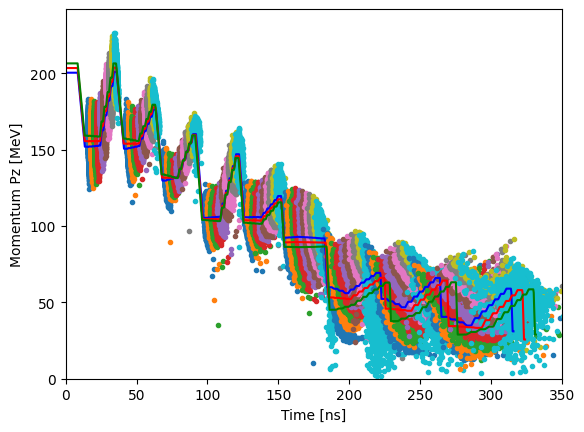

In [243]:
for md_solenoid in MD_solenoid_list:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')

plt.plot(sol_df1[sol_df1.IEVT==0]['T']*1E9, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'Mean KE - Ref')
plt.plot(sol_df0[sol_df0.IEVT==0]['T']*1E9, sol_df0[sol_df0.IEVT==0].Pz*1E3, 'r', label=f'-Sig KE')
plt.plot(sol_df2[sol_df2.IEVT==0]['T']*1E9, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'g', label=f'+Sig KE')
plt.xlim(0,350), plt.ylim(0,)
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

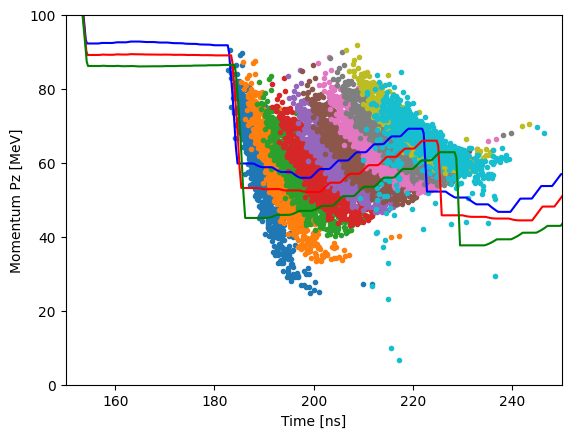

In [728]:
for md_solenoid in np.array(MD_solenoid_list)[get_matching_solenoid_index(7,0)]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')

plt.plot(sol_df1[sol_df1.IEVT==0]['T']*1E9, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'Mean KE - Ref')
plt.plot(sol_df0[sol_df0.IEVT==0]['T']*1E9, sol_df0[sol_df0.IEVT==0].Pz*1E3, 'r', label=f'-Sig KE')
plt.plot(sol_df2[sol_df2.IEVT==0]['T']*1E9, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'g', label=f'+Sig KE')
plt.xlim(150, 250), plt.ylim(0,100)
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

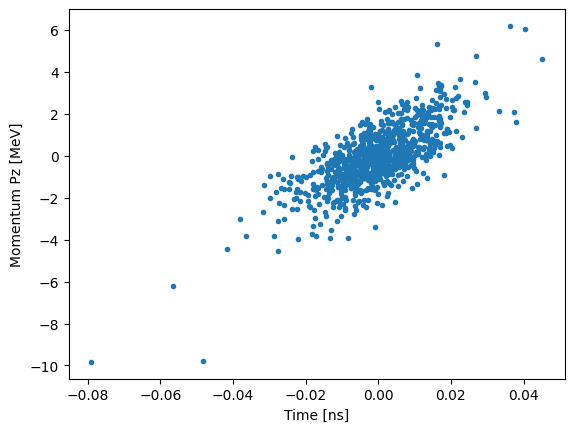

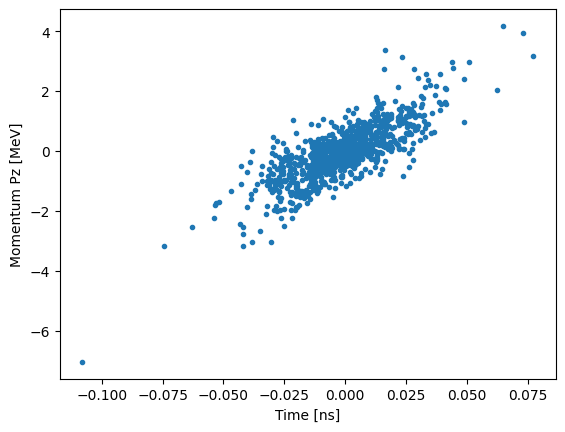

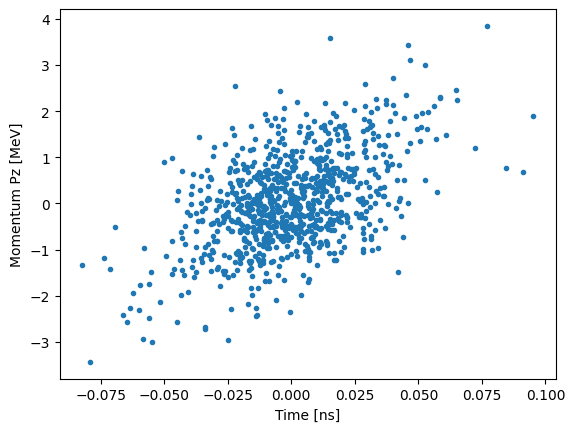

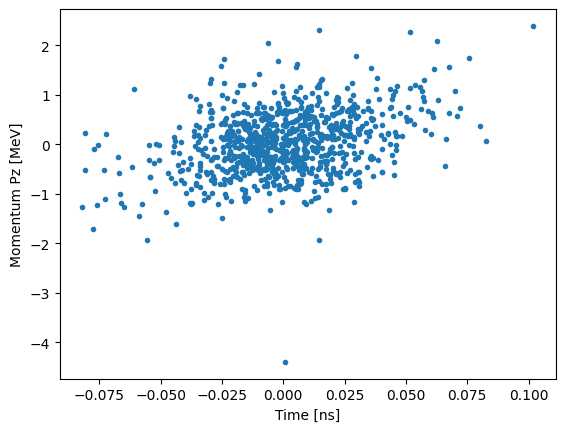

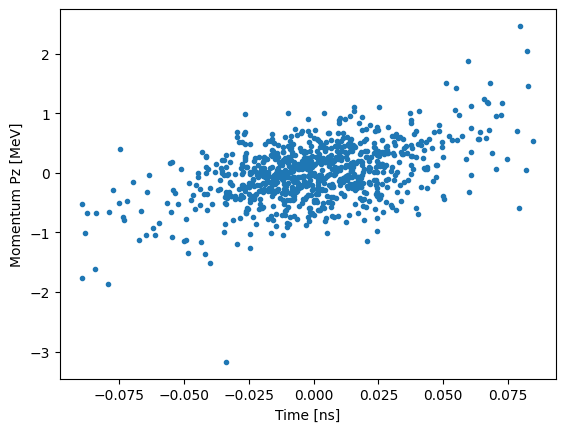

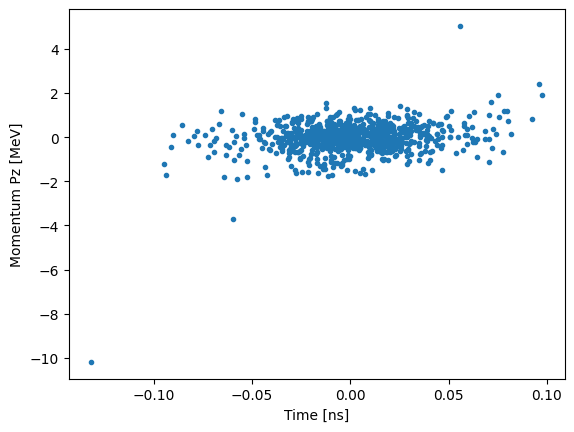

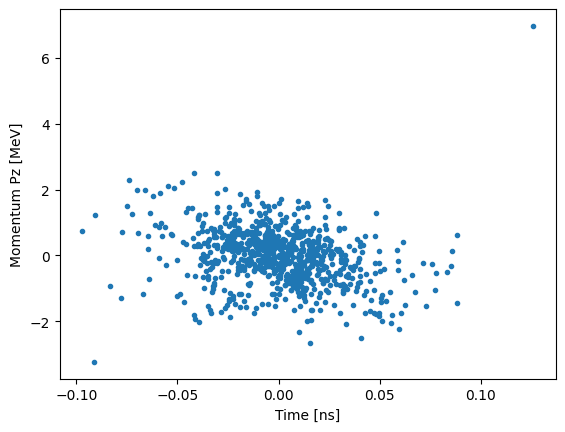

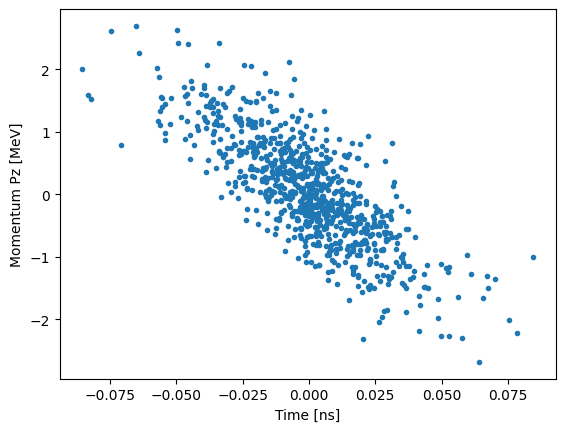

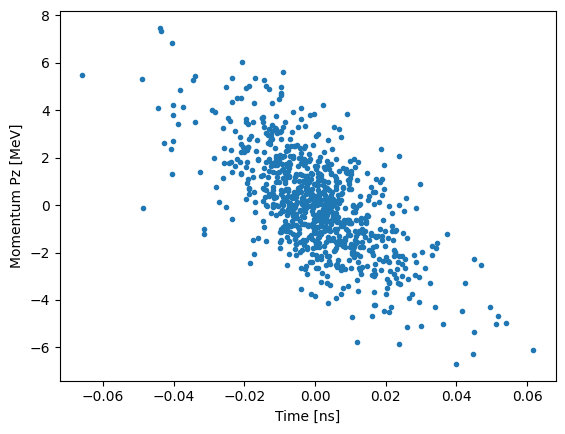

In [873]:
for md_solenoid in np.array(MD_solenoid_list)[get_matching_solenoid_index(7,0)[0:9]]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['X'][sol_df.Z == float(f'{Z:.1f}')], 1e3*sol_df['Px'][sol_df.Z == float(f'{Z:.1f}')], '.')

    plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')
    plt.show()

In [35]:
from tqdm.notebook import tqdm

In [422]:
Ez_arr = []
dEz_arr = []
dpp_arr = []
Transmission = []
Z_unique = sol_df.Z.unique()

for Zend in tqdm(sol_df.Z.unique()):
    pz_dist = np.array(sol_df['Pz'][(sol_df.Z == Zend)])*1E3
    Ez_dist = np.sqrt(pz_dist**2 + 105.65**2) - 105.65
    
    Ez_arr.append(np.mean(Ez_dist))
    dEz_arr.append(np.std(Ez_dist))
    dpp_arr.append(np.std(pz_dist)/np.mean(pz_dist))
    
    No_particles = len(sol_df['IEVT'][(sol_df.Z == Zend)].unique())
    Transmission.append(No_particles)

Ez_arr, dEz_arr = np.array(Ez_arr), np.array(dEz_arr)

  0%|          | 0/1201 [00:00<?, ?it/s]

In [423]:
emitT_arr, emitL_arr, emitz_arr, Z_arr = [], [], [], []
transmission_arr = []
Z_unique = sol_df.Z.unique()
for Z in tqdm(Z_unique):
    try:
        emitT, emitL, emitZ, L_ = compute_emit_from_phasespace(sol_df[(sol_df['Z'] == Z) & (sol_df['IEVT'] <100000)])
        emitT_arr.append(emitT), emitL_arr.append(emitL), emitz_arr.append(emitZ)
        Z_arr.append(Z)
        transmission_arr.append(len(sol_df[(sol_df['Z'] == Z) & (sol_df['IPTYP'] == 2)]))
    except ValueError:
        print(Z)

  0%|          | 0/1201 [00:05<?, ?it/s]

In [424]:
beta_arr, alpha_arr = [], []
for Z in tqdm(Z_unique):
    beta_, alpha_ = compute_optics_from_phasespace(sol_df[(sol_df['Z'] == Z) & (sol_df['IEVT'] <100000)])
    beta_arr.append(beta_), alpha_arr.append(alpha_)

  0%|          | 0/1201 [00:00<?, ?it/s]

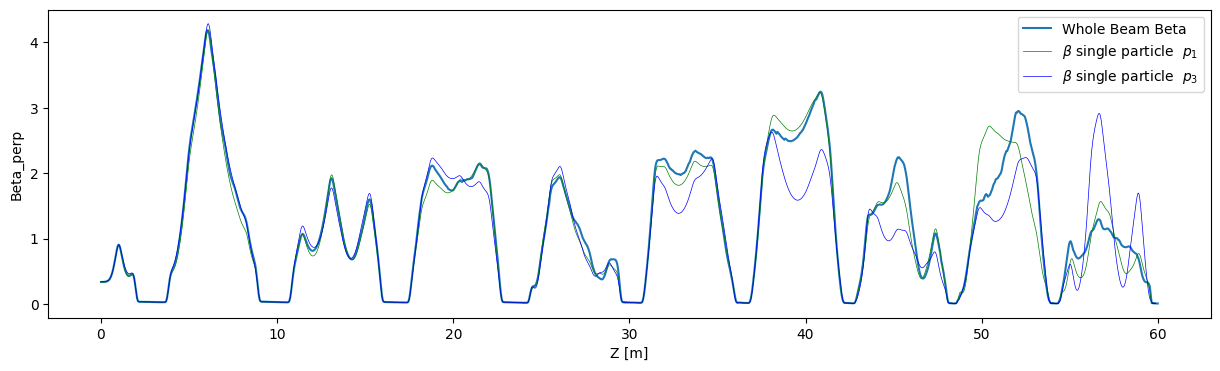

In [413]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr, np.array(beta_arr), label='Whole Beam Beta')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp')

plt.plot(s, beta_interp1, c='g', lw=0.5, label=r'$\beta$ single particle $\ p_1$')

plt.plot(s, beta_interp3, c='b', lw=0.5, label=r'$\beta$ single particle $\ p_3$')
plt.legend()

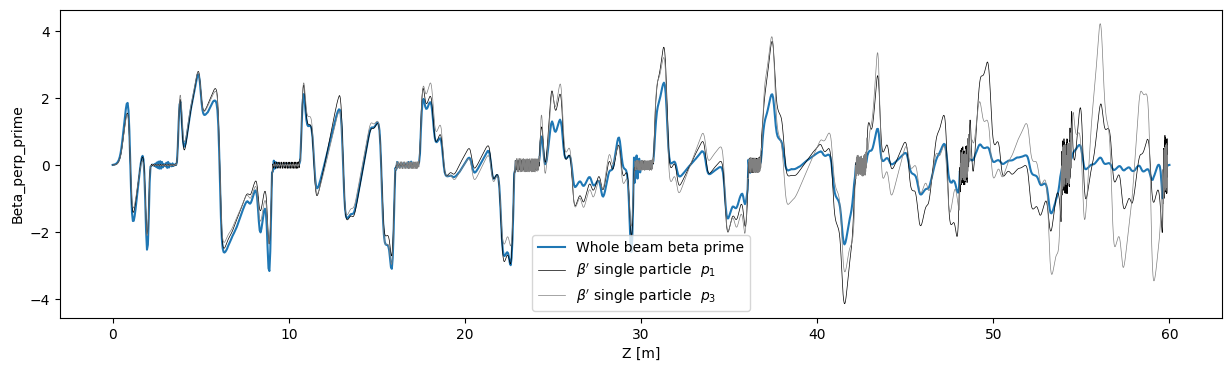

In [415]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')


plt.plot(s, betaP_interp1, c='k', lw=0.5,label=r'$\beta^{\prime}$ single particle $\ p_1$')

plt.plot(s, betaP_interp3, c='grey', lw=0.5,label=r'$\beta^{\prime}$ single particle $\ p_3$')
plt.legend()

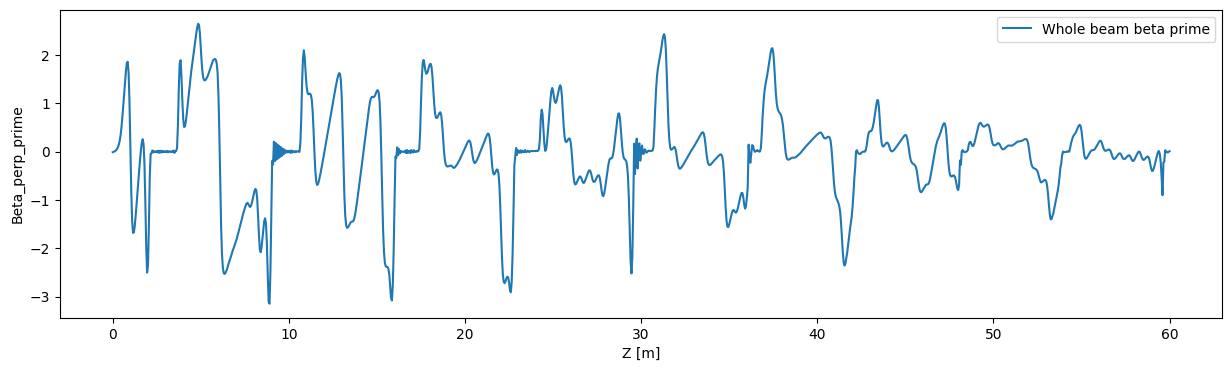

In [428]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')


plt.legend()

(50.0, 300.0)

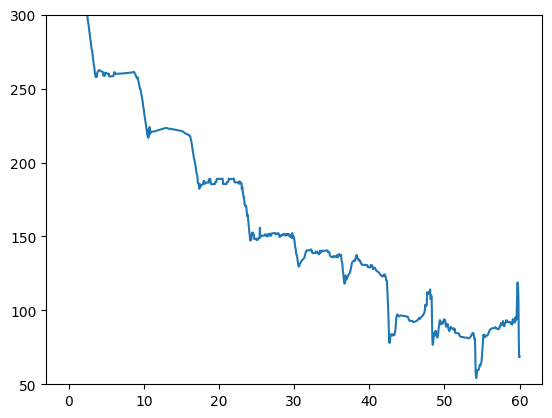

In [410]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

C:\Users\accel\AppData\Local\Temp\ipykernel_38320\3676978527.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


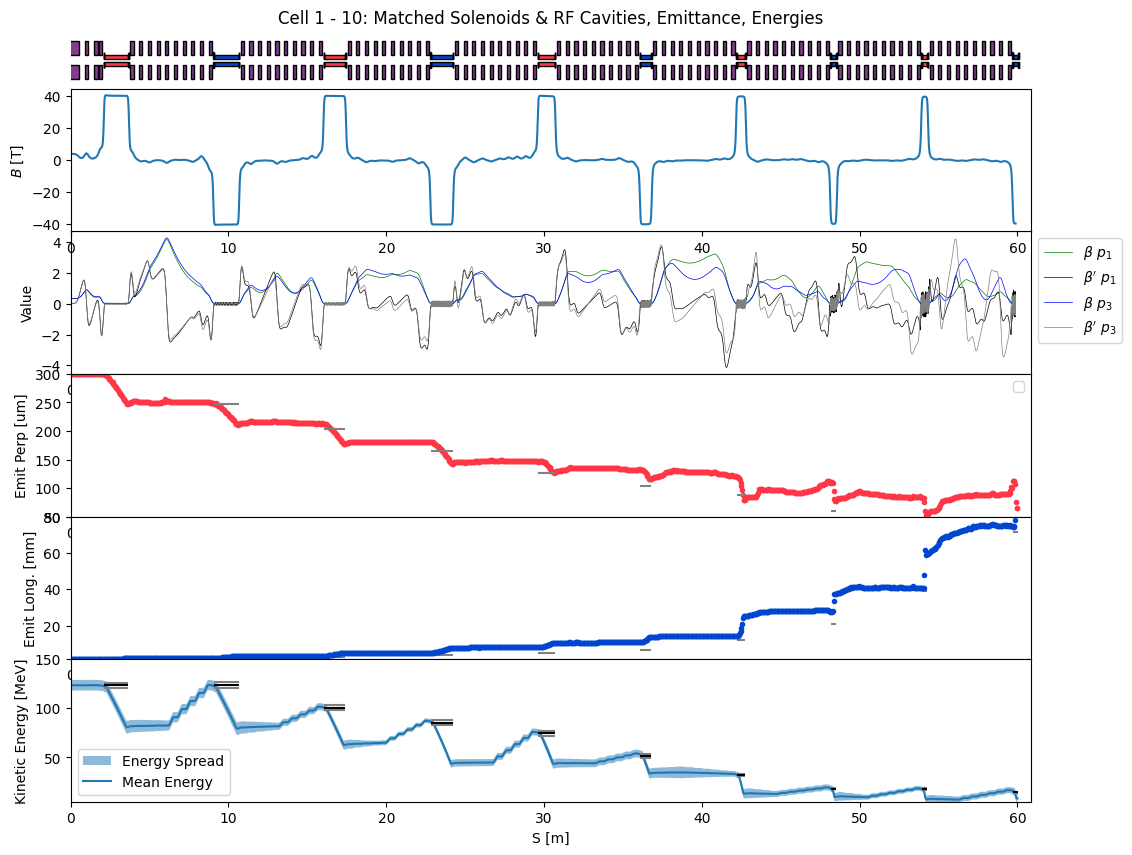

In [427]:
matplotlib.rcParams.update({'font.size': 10})

import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,10))
gs = mpl.gridspec.GridSpec(6, 2, height_ratios=[0.4, 1, 1,1,1,1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax4 = fig.add_subplot(gs[4])
ax3 = fig.add_subplot(gs[6])
ax5 = fig.add_subplot(gs[8])
ax2 = fig.add_subplot(gs[10])
ax6 = fig.add_subplot(gs[2])

plt.subplots_adjust(hspace=0)

I_max = H_current_density

ncell_match = 9
s_start, s_end = 0, H_solenoid_list[ncell_match].position
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 
max_S = s_end
max_r = 1

for solenoid in sol_list + MD_solenoid_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax1.set(xlim=(0, max_S+1), ylim=(-0.6, 0.6), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.fill_between(Z_unique, Ez_arr-dEz_arr, Ez_arr+dEz_arr, alpha=0.5, label='Energy Spread')
ax2.plot(Z_unique, Ez_arr, label='Mean Energy')
for i in range(10):
    ax2.hlines(Energies[i]-EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax2.hlines(Energies[i]+EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax2.hlines(Energies[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
#ax2.fill_between((H2_pos-1, H2_pos), (Energies[1]-EnergySpreads[1]/2, Energies[1]-EnergySpreads[1]/2), (Energies[1]+EnergySpreads[1]/2,Energies[1]+EnergySpreads[1]/2) , color='g', alpha=0)
ax2.set(xlim=(0, max_S+1), ylim=(5,150), xlabel='S [m]', ylabel='Kinetic Energy [MeV]')
ax2.legend(loc='lower left')

ax1.set_title('Cell 1 - 10: Matched Solenoids & RF Cavities, Emittance, Energies')

ax3.plot(Z_arr, np.array(emitT_arr)*1E6, '.', color=cmap(0))
ax3.set(xlabel='Z [m]',ylabel='Emit Perp [um]', ylim=(50,300), xlim=(0, max_S+1))

for i in range(10):
    ax3.hlines(1e6*EmitT_Target[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax5.hlines(1e3*EmitL_Target[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')

ax3.legend()

ax5.plot(Z_arr, np.array(emitL_arr)*1E3, '.', color=cmap(0.99))
ax5.set(xlabel='Z [m]',ylabel='Emit Long. [mm]', xlim=(0, max_S+1), ylim=(1.5, 80))


Mag_field = cp.MagneticField()
[Mag_field.add_solenoid(solenoid) for solenoid in sol_list + MD_solenoid_list];

p1 = p1_interp(s)
p2 = p2_interp(s)
p3 = p3_interp(s)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(Mag_field, s, p1, p2, p3)

# Plotting the results
ax4.plot(s, beta_interp1, c='g', lw=0.5, label=r'$\beta \ p_1$')
ax4.plot(s, betaP_interp1, c='k', lw=0.5,label=r'$\beta^{\prime} \ p_1$')
ax4.plot(s, beta_interp3, c='b', lw=0.5, label=r'$\beta \ p_3$')
ax4.plot(s, betaP_interp3, c='grey', lw=0.5,label=r'$\beta^{\prime} \ p_3$')
ax4.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S+1))
ax4.legend(bbox_to_anchor=(1.0, 1.0))


ax6.plot(s, B_superposed)
ax6.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S+1))

ax1.set_axis_off()
plt.savefig('PerformanceOverview_Diagram.png')
plt.show()

In [437]:
CellNo = range(0,10)
Z_per_cell = []
emitT_per_cell = []
emitL_per_cell = []
E_per_cell = []
sigE_per_cell = []
transmission_init = len(sol_df[sol_df.Z == 0])
transmission_per_cell = []

for cellno in CellNo:
    Z_after_cell = H_solenoid_list[cellno].position+H_solenoid_list[cellno].L_sol
    Z_index = np.max(np.where(Z_arr <= Z_after_cell))
    Z_per_cell.append(Z_arr[Z_index])
    emitT_per_cell.append(emitT_arr[Z_index]*1E6)
    emitL_per_cell.append(emitL_arr[Z_index]*1E3)
    E_per_cell.append(Ez_arr[Z_index])
    sigE_per_cell.append(dEz_arr[Z_index])
    transmission_per_cell.append(len(sol_df[sol_df.Z == Z_arr[Z_index]])/transmission_init)

In [438]:
PerformanceTable = pd.DataFrame()
PerformanceTable['Cell No'] = CellNo
PerformanceTable['Z End [m]'] = Z_per_cell
PerformanceTable['εT [μm]'] = emitT_per_cell
PerformanceTable['εL [mm]'] = emitL_per_cell
PerformanceTable['KE [MeV]'] = E_per_cell
PerformanceTable['σKE [MeV]'] = sigE_per_cell
PerformanceTable['Transm [%]'] = np.array(transmission_per_cell) * 100
PerformanceTable.round(1)

,Cell No,Z End [m],εT [μm],εL [mm],KE [MeV],σKE [MeV],Transm [%]
0,0,4.4,251.0,2.0,82.1,6.1,100.0
1,1,11.4,216.9,3.4,80.9,5.6,99.8
2,2,18.0,180.0,5.0,64.0,3.7,99.8
3,3,24.8,145.1,7.9,44.7,3.7,99.7
4,4,31.2,131.1,10.6,44.2,4.5,99.6
5,5,37.1,119.2,13.9,34.4,5.1,99.4
6,6,43.0,84.6,25.6,13.6,5.0,93.7
7,7,48.6,81.4,37.8,10.4,4.3,82.5
8,8,54.4,58.8,60.6,7.9,3.9,57.5
9,9,60.0,65.0,90.8,8.3,4.1,41.1


In [439]:
import tabulate
import re

Print to README file

In [440]:
md = PerformanceTable.to_markdown(index=False)
path = "README.md"

with open(path, "r", encoding="utf-8") as f:
    text = f.read()

# Regex: matches any markdown table (header row + separator row + body)
table_pattern = r"\|.*?\|\n\|[-| :]+\|\n(?:\|.*?\|\n)*"

if re.search(table_pattern, text, flags=re.DOTALL):
    updated = re.sub(table_pattern, md + "\n", text, flags=re.DOTALL)
else:
    updated = text.rstrip() + "\n\n" + md + "\n"

with open(path, "w", encoding="utf-8") as f:
    f.write(updated)

Text(0.5, 0, 'Z [m]')

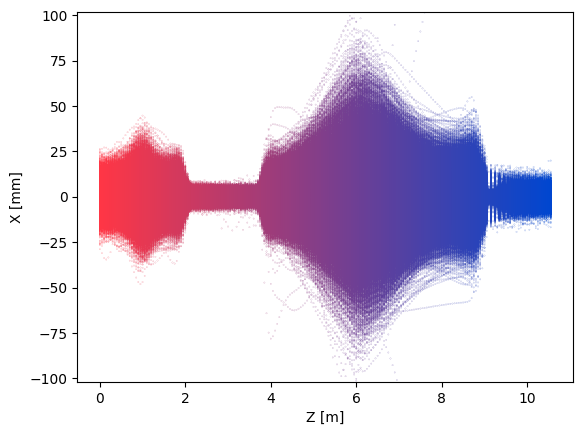

In [ ]:
plt.scatter(sol_df.Z, sol_df.X*1E3, s=0.01, c=sol_df.Z, cmap=cmap)
std_lim = 8
xlimmin, xlimmax = sol_df.X.mean()-std_lim*sol_df.X.std(), sol_df.X.mean()+std_lim*sol_df.X.std()
plt.ylim(xlimmin*1E3, xlimmax*1E3)
plt.ylabel('X [mm]')
plt.xlabel('Z [m]')

## Matching Time

- s_end should be after solenoid
- multilines instead of tuples (s_start, s_end)
- variables lower case (will be changed by code), constants all capital (I change value)
- Comment out code that shouldn't run
- Functions multi-line for expressions
- Truncated current density list: printed vs optimize-generated?
- Verify with same input - do not redefine
- collect as md

In [48]:
optimisation_map = [{} for i in range(9)] #To save results. index = NCELL_MATCH - 1, value = {"params": Array[float64], "target": float64}

In [ ]:
optimisation_map[0]['target'] = 0.0798772201077703
optimisation_map[0]['params'] =[35.508740647947036, -7.775637580448505, -12.148933874280392, 1.1659173138855703, -14.173355652807334, 3.1998081438712456, 2.3815554497724882, -9.459754369901425, 24.349408687342134, -45.67855729411018]
optimisation_map[1]['target'] = 0.1982577145695005
optimisation_map[1]['params'] =[-28.334138602427913, -18.431715440219733, -1.8529310774283174, -0.7396277735737722, -18.08609030347646, -8.54763195601096, 0.0009673962361045998, 9.52430341142502, 20.397960787679445, 29.556592977301975]
optimisation_map[2]['target'] = 1.1468224707775487
optimisation_map[2]['params'] =[21.012621654497096, 12.244461370921899, -11.097449571960091, -4.5045177322268195, -1.2384944237811228, -8.106579877886627, -0.022295960992406223, 11.267593100105538, -15.663338462735148, -24.942415716187753]
optimisation_map[3]['target'] = 0.14975070590128897
optimisation_map[3]['params'] =[-29.881346668714592, 16.744336886371848, -11.819662580805698, 9.950325737531157, -7.483195432733175, 8.724360618218066, 13.792092053439175, 17.363911559598638, 18.412403662763268, 32.41448982831251]
optimisation_map[4]['target'] = 5.410727683740672
optimisation_map[4]['params'] =[11.369558929743466, 12.310983999339264, -7.198581912134298, 0.7722998442491082, -1.3293470467535062, 7.025454878824878, 1.1407216424801891, 11.469503794614873, -7.918146505524364, -21.16029651285568]
optimisation_map[5]['target'] = 2.721325395672316
optimisation_map[5]['params'] =[-9.351199516185929, -8.265483470824226, -5.642855921818294, -1.6810582839808403, -0.10171718576806638, -0.7056563222222092, -3.4193851559764092, 6.131475790137806, 8.008457203287477, 9.299822544002978]
optimisation_map[6]['target'] =  22.19041189811812
optimisation_map[6]['params'] = [9.624468716039766, -9.324565389943977, 4.326785225065006, -0.7090221674743798, 4.362659912062138, 4.874453378459519, 6.053490535581844, -5.951154118618279, -8.929289891280256, -10.339666714341734] 
optimisation_map[7]['target'] = 20.24955452087128
optimisation_map[7]['params'] = [-14.243520148161284, -3.9799448759707445, -4.143549649541122, 3.082906352333689, -1.4714315400077336, -0.8646284599752555, -3.6464585837122376, -3.5412533983902885, 6.458774655409737, 7.94456662324942]
optimisation_map[8]['target'] = 22.86935794000124
optimisation_map[8]['params'] =[5.480966851669825, 6.2700322480439485, 3.08371205492843, -3.770484877114579, -3.842548209627757, 4.040535591225504, 4.9168448694401, -5.48582024646873, -7.849888638102266, -7.573050278493454]

In [53]:
for cellno in range(1):
    for m, matcher in enumerate(np.array(MD_solenoid_list)[get_matching_solenoid_index(cellno+1,0)]):
        matcher.current_density = optimisation_map[cellno]['params'][m]

In [372]:
NCELL_MATCH = 9
N_MAGNETS = 10
BOUND_MIN = -8
BOUND_MAX = 8

half_sol_len = H_solenoid_list[NCELL_MATCH].L_sol/2
half_abs_len = AbsorberLengths[NCELL_MATCH]/2

s_start = 0
s_end = H_solenoid_list[NCELL_MATCH].position + half_sol_len*1.2 #Extra 20% after solenoid
s_array = np.arange(s_start, s_end, 0.001) 

In [373]:
bounds = np.tile([BOUND_MIN, BOUND_MAX], [N_MAGNETS, 1]) #current_density
options = {'maxiter': 10000} #scipy minimize algo iterations

sol_list = [L1] + MU1_list + H_solenoid_list + HcorrU_solenoid_list + HcorrD_solenoid_list

opt_point = H_solenoid_list[NCELL_MATCH].position
#points = np.array([opt_point-0.7, opt_point-0.6, opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5, opt_point+0.6, opt_point+0.7])
#points = np.array([opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5])
points = np.arange(H_solenoid_list[NCELL_MATCH].position-half_abs_len, H_solenoid_list[NCELL_MATCH].position+half_abs_len, 0.01)

In [389]:
MD_optimized_params = [MD1_optimized_params, MD2_optimized_params, MD3_optimized_params, MD4_optimized_params, MD5_optimized_params, MD6_optimized_params, MD7_optimized_params, MD6_optimized_params, MD7_optimized_params]
#optimized_params = [5.363608558421946, 4.2221635366677255, 2.1352014653553595, 2.2253157705147224, -0.766951629534041, 1.8864367714160273, 3.148696993257979, -3.91578377964444, -4.674382526853414, -5.4650833282843285]  # [5.367766476847346, 4.222912360003364, 2.1412316703636676, 2.229123600033648, -0.7653852503942373, 1.8885438199983164, 3.142039944186758, -3.904686513914438, -4.636546745808699, -5.453827573250289]
optimized_params =  [6, 5.682180570169185, 3.120577679278345, -5.672117861698032, -3.4414477142583753, 3.7138599862163137, 4.221779138970285, -6.235067770233478, -7.305751821486866, -7.414905770919347]
#optimized_params = optimisation_map[NCELL_MATCH-1]['params']
#optimized_params = 11.369558929743466, 12.310983999339264, -7.198581912134298, 0.7722998442491082, -1.3293470467535062, 7.025454878824878, 1.1407216424801891, 11.469503794614873, -7.918146505524364, -21.16029651285568 # [20, 15, 10, 5, 1, -1, -5, -10, -15, -20] # [-14, -10, -5, -1, 1, 5, 10, 15, 20, 25]

result = minimize(
    objective,
    optimized_params,
    args=(
        get_matching_solenoid_index(NCELL_MATCH,0),
        deepcopy(MD_solenoid_list), #to not change the list itself until value is approved
        s_array,
        sol_list,
        p1_interp,
        p2_interp,
        p3_interp,
        points,
        [1,0,1,100],#, #w1, w2, w3, wprime
        5 #Encourage beta lower than
    ),
    method='nelder-mead',
    jac=None,
    bounds=bounds,
    options=options,
    tol=1e-3
)

optimized_params = result.x
print('Result ', optimized_params.tolist())

[6.0, 5.682180570169185, 3.120577679278345, -5.672117861698032, -3.4414477142583753, 3.7138599862163137, 4.221779138970285, -6.235067770233478, -7.305751821486866, -7.414905770919347] 2964.700702028306
[6.300000000000001, 5.682180570169185, 3.120577679278345, -5.672117861698032, -3.4414477142583753, 3.7138599862163137, 4.221779138970285, -6.235067770233478, -7.305751821486866, -7.414905770919347] 2387.3678423374163
[6.0, 5.966289598677645, 3.120577679278345, -5.672117861698032, -3.4414477142583753, 3.7138599862163137, 4.221779138970285, -6.235067770233478, -7.305751821486866, -7.414905770919347] 2613.1809973029685
[6.0, 5.682180570169185, 3.2766065632422623, -5.672117861698032, -3.4414477142583753, 3.7138599862163137, 4.221779138970285, -6.235067770233478, -7.305751821486866, -7.414905770919347] 2361.1711976271604
[6.0, 5.682180570169185, 3.120577679278345, -5.955723754782934, -3.4414477142583753, 3.7138599862163137, 4.221779138970285, -6.235067770233478, -7.305751821486866, -7.4149057

In [391]:
optimisation_result, optimisation_target = [5.480966851669825, 6.2700322480439485, 3.08371205492843, -3.770484877114579, -3.842548209627757, 4.040535591225504, 4.9168448694401, -5.48582024646873, -7.849888638102266, -7.573050278493454], 22.86935794000124

In [392]:
# == VERIFICATION CELL ==
objective_value = objective(
    np.array(optimisation_result),
    get_matching_solenoid_index(NCELL_MATCH, 0),                                          
    deepcopy(MD_solenoid_list),
    s_array,
    sol_list,
    p1_interp,
    p2_interp,
    p3_interp,
    points,
    [1,0,1,100],
    5
)

# We confirm if our optimised value matches our objective value.
# If so, save it to be checked contextually later.
if objective_value == optimisation_target:
    print('Achieved expected target')
    optimisation_map[NCELL_MATCH - 1] = {
        "params": optimisation_result,
        "target": optimisation_target,
        "matchers" : MD_solenoid_list
    }
    for m, matcher in enumerate(np.array(MD_solenoid_list)[get_matching_solenoid_index(NCELL_MATCH,0)]):
        matcher.current_density = (optimisation_map[NCELL_MATCH - 1]["params"])[m]
    print('Saved to MD_solenoid_list')
else:
    print(f"Expected {optimisation_target}, achieved {objective_value}")

[5.480966851669825, 6.2700322480439485, 3.08371205492843, -3.770484877114579, -3.842548209627757, 4.040535591225504, 4.9168448694401, -5.48582024646873, -7.849888638102266, -7.573050278493454] 22.86935794000124
Achieved expected target
Saved to MD_solenoid_list


In [393]:
# == UPSTREAM VERIFICATION ==
for index, optimised_solenoid in enumerate(optimisation_map):
    try:
        print(f"Checking Cell {index+1}. Target is {optimised_solenoid['target']}")
        updated_value = objective(
            np.array(optimised_solenoid['params']),
            get_matching_solenoid_index(index + 1, 0),
            deepcopy(MD_solenoid_list),
            s_array,
            sol_list,
            p1_interp,
            p2_interp,
            p3_interp,
            np.arange(H_solenoid_list[index + 1].position-AbsorberLengths[index + 1]/2, H_solenoid_list[index + 1].position+AbsorberLengths[index + 1]/2, 0.01), #points,
            [1,0,1,100]
        )
    except:
        print(optimised_solenoid)

Checking Cell 1. Target is 0.0798772201077703
[35.508740647947036, -7.775637580448505, -12.148933874280392, 1.1659173138855703, -14.173355652807334, 3.1998081438712456, 2.3815554497724882, -9.459754369901425, 24.349408687342134, -45.67855729411018] 0.07910755069993672
Checking Cell 2. Target is 0.1982577145695005
[-28.334138602427913, -18.431715440219733, -1.8529310774283174, -0.7396277735737722, -18.08609030347646, -8.54763195601096, 0.0009673962361045998, 9.52430341142502, 20.397960787679445, 29.556592977301975] 0.26237606205263564
Checking Cell 3. Target is 1.1468224707775487
[21.012621654497096, 12.244461370921899, -11.097449571960091, -4.5045177322268195, -1.2384944237811228, -8.106579877886627, -0.022295960992406223, 11.267593100105538, -15.663338462735148, -24.942415716187753] 1.8896415006733025
Checking Cell 4. Target is 0.14975070590128897
[-29.881346668714592, 16.744336886371848, -11.819662580805698, 9.950325737531157, -7.483195432733175, 8.724360618218066, 13.792092053439175

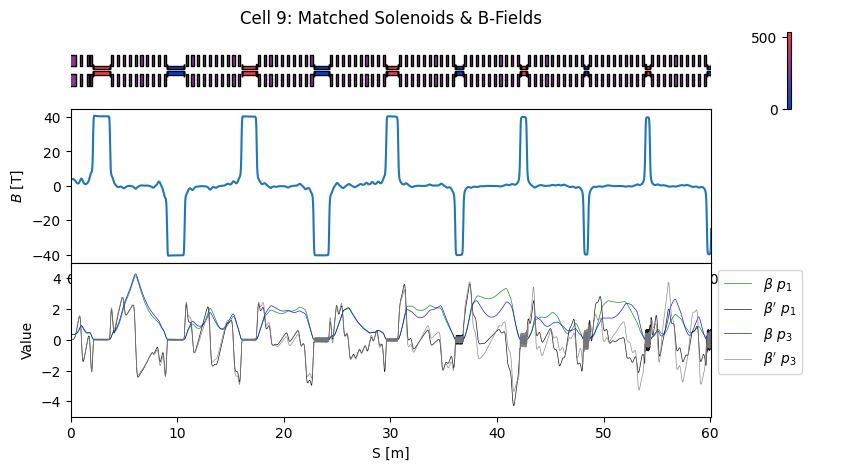

In [395]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(10,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes~
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

ncell_match = NCELL_MATCH

sol_list_test = sol_list + MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S), ylim=(-5,5))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title(f'Cell {ncell_match}: Matched Solenoids & B-Fields')
plt.show()

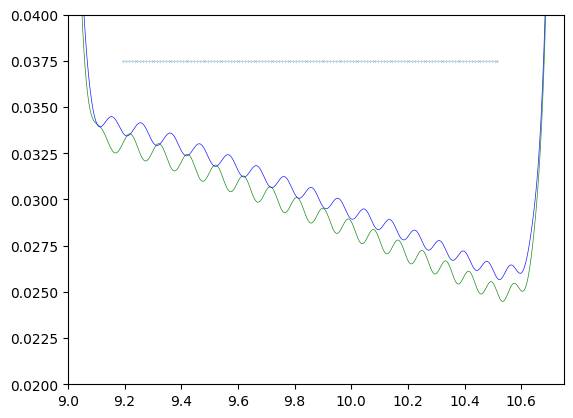

In [191]:
plt.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
plt.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
plt.xlim(9,10.75)
plt.ylim(0.02, 0.04)

points = np.arange(H_solenoid_list[1].position-AbsorberLengths[1]/2, H_solenoid_list[1].position+AbsorberLengths[1]/2, 0.01)
plt.plot(points, 0.0375*np.ones(len(points)), '.', markersize=0.5)

#### Gif Creation

In [ ]:
def create_gif(gifname):
    m_mu = 0.105658375
    
    coord_arr = ['X [mm]', 'PX [MeV]', 'Y [mm]', 'PY [MeV]', 't [mm/c]', 'E [GeV]']
    index_arr = [1,2,3,4,5,6]
    axes_indices = [[0,1], [0,3], [0,2], [2,1], [2,3], [4,5]]
    coord_indices = [['X', 'Px'], ['X','Py'], ['X','Y'], ['Y','Px'], ['Y','Py'], ['T','Pz']]
    Zunique = sol_df.Z.unique()

    std = 10
    maxes = [sol_df.X.mean()+std*sol_df.X.std(), sol_df.Px.mean()+std*sol_df.Px.std(), sol_df.Y.mean()+std*sol_df.Y.std(), sol_df.Py.mean()+std*sol_df.Py.std()]
    mins =  [sol_df.X.mean()-std*sol_df.X.std(), sol_df.Px.mean()-std*sol_df.Px.std(), sol_df.Y.mean()-std*sol_df.Y.std(), sol_df.Py.mean()-std*sol_df.Py.std()]

    with imageio.get_writer(f"{os.getcwd()}/gifs/{gifname}.gif", mode='I') as writer:
        for z, Z in enumerate(Zunique):
            print(Z, '/', sol_df.Z.max())

            beam = sol_df[sol_df.Z == Z]
            X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
            E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5
            data = np.stack([X, PX, Y, PY, T, E])
            means = np.mean(data, axis=1)
            stds = np.std(data, axis=1)
            # Identify high amplitude particles (above 5 sigma)
            sigma = 5
            filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
            # Filter the data
            filtered_data = data[:, filtered_indices]

            fig = plt.figure(figsize=(12, 4.5))
            gs = fig.add_gridspec(2, 4, width_ratios=[2.5, 1, 1, 1], height_ratios=[1, 1])
            
            # Add subplots to the grid
            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[1, 0])
            ax3 = fig.add_subplot(gs[0, 1])
            ax4 = fig.add_subplot(gs[0, 2])
            ax5 = fig.add_subplot(gs[0, 3])
            ax6 = fig.add_subplot(gs[1, 1])
            ax7 = fig.add_subplot(gs[1, 2])
            ax8 = fig.add_subplot(gs[1, 3])
            
            axes=[ax3,ax4,ax5,ax6,ax7,ax8]

            for i, ax in enumerate(axes):
                ax.set_xlabel(coord_arr[axes_indices[i][0]]), ax.set_ylabel(coord_arr[axes_indices[i][1]])

                scatter = ax.scatter(filtered_data[axes_indices[i][0],:], filtered_data[axes_indices[i][1],:], s=2, c=filtered_data[5], cmap=cmap)
                if i < 5:
                    ax.set(xlim=(mins[axes_indices[i][0]], maxes[axes_indices[i][0]]),
                        ylim=(mins[axes_indices[i][1]], maxes[axes_indices[i][1]]))
                    
            ax1.set_ylabel(r'$\varepsilon_\perp [$ mm]'), ax2.set_ylabel(r'$\varepsilon_\parallel [$ mm]')
            ax2.set_xlabel('S [m]')
            # Remove ticks, labels, and frame from ax10
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            ax3.set_title(f'Position {Z} m')

            ax1.plot(Zunique[:z], np.array(emitT_arr)[:z]*1E6, color='#0046d0')
            ax2.plot(Zunique[:z], np.array(emitL_arr)[:z]*1E3, color='#0046d0')
            ax1.set(xlim=(min(Zunique), max(Zunique)), ylim=(min(np.array(emitT_arr)*1E6), 300), xlabel='S [m]', ylabel=r'$\varepsilon_\perp [$ mm]')
            ax2.set(xlim=(min(Zunique), max(Zunique)), ylim=(min(np.array(emitL_arr)*1E3), 70), xlabel='S [m]', ylabel=r'$\varepsilon_\parallel [$ mm]')
                    
            plt.savefig(f"{os.getcwd()}/gifs/screen_{Z}.png")
            #plt.close(fig)
            image = imageio.imread(f"{os.getcwd()}/gifs/screen_{Z}.png")
            writer.append_data(image)
            os.remove(f"{os.getcwd()}/gifs/screen_{Z}.png")

In [875]:
import imageio.v2 as imageio
import os


In [ ]:
create_gif('10Cell_Ver0.0')